In [391]:
from typing import Callable
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

class MIT:
    def __init__(self):
        pass

    def multiview_iteration(self, df_t:pd.DataFrame, max_iter:int=100, household_idx:int=1):
        assert df.columns.tolist() == ["Energy", "Time", "Occupancy"]

        # line1
        df_t = self._prior(df_t, household_idx)
        df_t["preds_t"] = df_t["preds_time"]

        stop_condition = False
        t = 1
        eta_t = 0.1
        print("line1 completed")
        remain_sample_dfs = pd.DataFrame()
        while (not stop_condition)&(t < max_iter):

            # line2-5
            model_energy = DecisionTreeClassifier(max_depth=3)
            model_energy.fit(df_t.Energy.values.reshape(-1, 1), df_t.preds_t.values.reshape(-1, 1))
            df_t["preds_energy"] = model_energy.predict(df_t.Energy.values.reshape(-1, 1))
            print("line2-5 completed")

            # line6
            df_t["preds_majority_vote"] = df_t.preds_energy | df_t.preds_t
            print("line6 completed")

            # line 7
            print("line7 completed")

            # line 8
            df_tplus1 = df_t[df_t.preds_t == df_t.preds_majority_vote]
            synmetric_diff_sample_df, remain_sample_df = self._synmetric_diff_sample(df_t)
            remain_sample_dfs = pd.concat([remain_sample_dfs, remain_sample_df], axis=0)
            df_tplus1 = pd.concat([df_tplus1, synmetric_diff_sample_df], axis=0)
            print("line8 completed")

            # line 9
            eta_tplus1 = self._est_eta(df_tplus1)
            stop_condition = self._check_if_stop(df_t, df_tplus1, eta_tplus1, eta_t)
            
            df_tplus1["preds_t"] = df_tplus1["preds_majority_vote"]
            df_t = df_tplus1
            eta_t = eta_tplus1
            t += 1
            print("line9 completed")
        print("algo completed")
        return df_t, remain_sample_dfs

    def _prior(self, df, household_idx=1):
        if household_idx in [2]:
            preds_time = []
            for _, row in df.iterrows():
                if (row.Time >= 18) & (row.Time <= 40):
                    preds_time.append(0)
                else:
                    preds_time.append(1)
            df["preds_time"] = preds_time
        elif household_idx in [1, 3]:
            preds_time = []
            for _, row in df.iterrows():
                if (row["Time"] >= 24) & (row["Time"] <= 28):
                    preds_time.append(0)
                else:
                    preds_time.append(1)
            df["preds_time"] = preds_time
        return df
    def _synmetric_diff_sample(self, df_old, alpha_0=0.9, alpha_1=0.9):
        synmetric_diff = pd.DataFrame()
        synmetric_diff = df_old[df_old.preds_t != df_old.preds_majority_vote]
        df_len = synmetric_diff.shape[0]
        print(df_len)
        
        synmetric_diff_sammple_0 = synmetric_diff[synmetric_diff.preds_majority_vote == False]
        synmetric_diff_sammple_1 = synmetric_diff[synmetric_diff.preds_majority_vote == True]
        
        sample_0_thr = int(synmetric_diff_sammple_0.shape[0]*alpha_0)
        sample_1_thr = int(synmetric_diff_sammple_1.shape[0]*alpha_1)
        remain_sample = pd.concat([synmetric_diff_sammple_0[sample_0_thr:], synmetric_diff_sammple_1[sample_1_thr:]], axis=0)
        synmetric_diff_sammple_0 = synmetric_diff_sammple_0[:sample_0_thr]
        synmetric_diff_sammple_1 = synmetric_diff_sammple_1[:sample_1_thr]
        return pd.concat([synmetric_diff_sammple_0, synmetric_diff_sammple_1], axis=0), remain_sample

    def _est_eta(self, df):
        num = sum((df.preds_t==1)&(df.preds_majority_vote==0)) + sum((df.preds_t==0)&(df.preds_majority_vote==1))
        det = df.shape[0]
        return num/det
    
    def _check_if_stop(self, df_t, df_tplus1, eta_tplus1, eta_t):
        return df_tplus1.shape[0]*(1-2*eta_tplus1)**2 > df_t.shape[0]*(1-2*eta_t)**2

In [392]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [393]:
target_idx = 2
summer_idx = 1

In [394]:
target_X = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_X_train.csv")
target_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_Y_train.csv")[target_X.Season==summer_idx]
target_X = target_X[target_X.Season==summer_idx]

In [395]:
mit = MIT()

In [396]:
target_X

,Energy,Season,Time
0,380827.893,1,12
1,194841.812,1,13
2,122493.428,1,14
3,155853.417,1,15
4,158295.543,1,16
...,...,...,...
2171,200783.630,1,39
2172,197410.112,1,40
2173,195676.564,1,41
2174,195884.090,1,42


In [397]:
target_y_task

,Occupancy
0,1
1,1
2,0
3,0
4,0
...,...
2171,0
2172,0
2173,0
2174,0


In [398]:
df = pd.concat([target_X, target_y_task], axis=1).drop(columns="Season")
df, remain_sample_dfs = mit.multiview_iteration(df, max_iter=100, household_idx=target_idx)
df = pd.concat([df, remain_sample_dfs], axis=0).sort_index()

line1 completed
line2-5 completed
line6 completed
line7 completed
10
line8 completed
line9 completed
algo completed


target acc: 0.5183823529411765


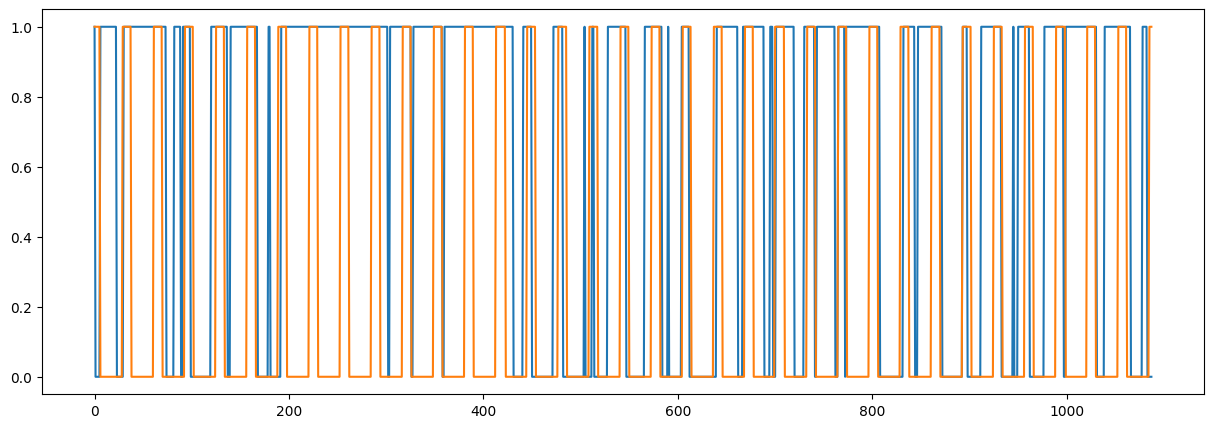

In [399]:
test_thr = int(df.shape[0]*0.5)
acc = sum(df["Occupancy"][test_thr:] == df["preds_majority_vote"][test_thr:])/test_thr
print(f"target acc: {acc}")
plt.figure(figsize=(15, 5))
plt.plot(df["Occupancy"].values[test_thr:])
plt.plot(df["preds_majority_vote"].values[test_thr:])